# Lab: Course 4, Module 4

### Step 0

Imagine you're a data scientist at a healthcare startup tasked with analyzing patient data to improve breast cancer diagnosis. Importing the necessary libraries and setting up a Spark session ensures you have the computational tools to handle large-scale data, just like a doctor gathers essential instruments before starting a procedure.

**Import the germane library**

In [1]:
# CodeGrade step0
from pyspark.sql import SparkSession
from pyspark.sql.functions import min, max
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a Spark session
spark = SparkSession.builder \
    .appName("Breast Cancer Analysis") \
    .getOrCreate()

### Step 1

Hospitals rely on efficient systems to process and analyze patient records. By verifying the Spark session, you're ensuring the system is operational and ready to handle critical tasks, much like checking that medical equipment is functioning before use.

**Create a Spark session where the name is "Breast Cancer Analysis" and verify that it is running such that if it is, the reponse is `yes`.**

In [2]:
# CodeGrade step1

if (spark.getActiveSession()):
    print('yes')
else:
    print('no')

yes


### Step 2

In real-world scenarios, data scientists often collaborate with clinicians to answer specific queries, such as reviewing key patient metrics. Here, you're tasked with loading the dataset and pinpointing specific details (e.g., the perimeter mean of the 77th row), mirroring how teams use data to address targeted medical questions.

*   **Load the data**
*   **Display records and data types**
*   **Find the permimter mean of the 77th row**
  * **Call this `permiter_mean_value`**




In [3]:
# CodeGrade step0

# Load the data
df = spark.read.csv("breast_cancer.csv", header=True, inferSchema=True)


In [4]:
# Run this code

# Display records and data types
df.show(5)
df.printSchema()

+--------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+----+
|      id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|_c32|
+--------+---------+-----------+------

In [5]:
# CodeGrade step2
# Find the perimeter mean of the 77th row
# Call this perimeter_mean_value

# df.select('perimeter_mean') creates a new df with one column: perimeter_mean
# .rdd converts spark df into RDD, so each row is a row object
# .zipwithindex attaches an index to each row in the index 1
# .filter(lambda x: x[1] == 76), keep only the index 1 of the tuple where its value is 76 (77th row)
#  .map(lambda x: x[0][0] x[0] is row object, x[0][0] is first value in that row (perimeter mean value)
# .collect()[0] collect that result and get the first value in the list
perimeter_mean_value = df.select('perimeter_mean').rdd.zipWithIndex().filter(lambda x: x[1] == 76).map(lambda x: x[0][0]).collect()[0]

perimeter_mean_value

87.91

### Steps 3 & 4

To design effective diagnostic tools, understanding the dataset’s summary statistics is vital. This step emulates how medical professionals analyze patterns in patient data to gain insights into critical health indicators, such as tumor size or perimeter mean.


**Step 3: Find the counts of the number of Benight and Malignant diagnosis, and then take the difference of the two (B - M).**

Oncologists might want to examine specific groups of patients to identify patterns or anomalies. Filtering the data simulates this process, helping uncover insights like identifying patients with high-risk profiles based on specific attributes.

**Step 4: Do this as a SQL query**
  * **  *Hint*: Use `df.createOrReplaceTempView()` to be able to find these counts using SQL **



In [6]:
# CodeGrade step3

# group diagnosis column and count rows
diag_counts = df.groupBy('diagnosis').count()

# filter grouped df to get only malignant and benign rows
diag_m = diag_counts.filter(diag_counts['diagnosis'] == 'M')
diag_b = diag_counts.filter(diag_counts['diagnosis'] == 'B')

# .show() -> triggers action to show diag_m and diag_b df's
diag_m.show()
diag_b.show()

# extract the count value from each df using .collect()
# access first row and 'count' column
diag_diff = diag_b.collect()[0]['count'] - diag_m.collect()[0]['count']
diag_diff

+---------+-----+
|diagnosis|count|
+---------+-----+
|        M|  212|
+---------+-----+

+---------+-----+
|diagnosis|count|
+---------+-----+
|        B|  357|
+---------+-----+



145

In [7]:
# CodeGrade step4
df.createOrReplaceTempView('breast_cancer_table')

# sum how many times each value (M or B) appears
# use SUM with CASE inside an aggregation
diagnosis = spark.sql("""
    SELECT COUNT(*) AS total,
        SUM(CASE WHEN diagnosis = 'M' THEN 1 ELSE 0 END) AS diag_m,
        SUM(CASE WHEN diagnosis = 'B' THEN 1 ELSE 0 END) AS diag_b
    FROM breast_cancer_table
    """)
diagnosis.show()

# .collect() gets the only row, ['diag_X'] gets the column values
diag_m = diagnosis.collect()[0]['diag_m']
diag_b = diagnosis.collect()[0]['diag_b']

diag_diff = diag_b - diag_m
diag_diff

+-----+------+------+
|total|diag_m|diag_b|
+-----+------+------+
|  569|   212|   357|
+-----+------+------+



145

### Step 5

You're part of a public health team working to understand the prevalence of different types of breast cancer diagnoses in a population. To gain insights, you’re tasked with visualizing the distribution of benign (B) and malignant (M) cases. This plot will help illustrate the balance between the two diagnosis classes, aiding stakeholders in understanding the overall dataset composition.

For example, a significant imbalance might indicate a need for better early detection programs to catch malignant cases earlier, or it might reflect the population's overall health profile. By labeling the chart as "Diagnosis Class Balance," you’re creating a clear and intuitive visualization that can be presented to medical professionals and policymakers to inform decisions on resource allocation or research focus areas.


**Create a bar plot to show the distribution of benign and malignant cases.**
* ***Hint*: It will be useful to convert back to pandas so you can use `matplotlib` and `pandas` visualization tools.**
* The code to create the plots is included, using a SQL query in conjunction with pyspark, create a dataframe “diagnosis_counts” that contains the appropriate information to plot.
* Label the Count columns as “count”


In [8]:
# CodeGrade step5
diagnosis_counts = spark.sql("""
    SELECT diagnosis, COUNT(*) AS count
    FROM breast_cancer_table
    GROUP BY diagnosis
    """)

diagnosis_counts = diagnosis_counts.toPandas()

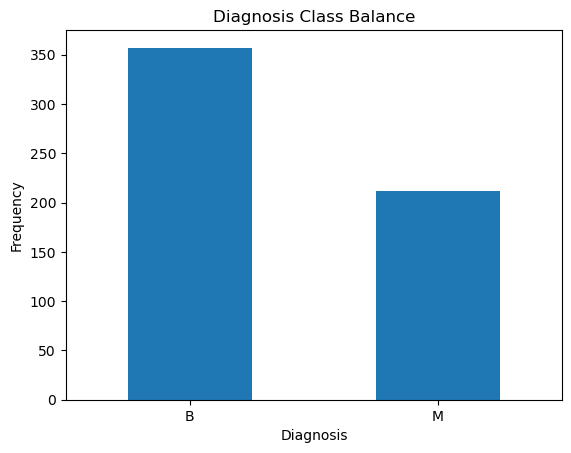

In [9]:
# Run this code

# Plot diagnosis class balance
diagnosis_counts.plot(kind="bar", x="diagnosis", y="count", legend=False, rot=0)
plt.title("Diagnosis Class Balance")
plt.xlabel("Diagnosis")
plt.ylabel("Frequency")
plt.show()

### Step 6

Hospitals often look for trends, such as average tumor sizes, across different patient groups. Aggregating the data allows you to provide actionable insights, just as hospital administrators use statistics to guide resource allocation and policy decisions.

**Use .describe() to see statistics for each feature, which will help you understand the ranges and distributions of the data.**

**Then use the 'pyspark.sql.functions' of 'min' and 'max' to find the**
* **maximum of the `compactness_mean`**
* **minimum of the `smoothness_mean`**

**Take the difference of the `max_compactness_mean` and `min_snmoothness_mean`.**

In [10]:
# Run this code

# Summary statistics
df.describe().show()

+-------+--------------------+---------+------------------+-----------------+-----------------+-----------------+--------------------+-------------------+-------------------+--------------------+--------------------+----------------------+------------------+------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+--------------------+-------------------+-------------------+--------------------+-------------------+-----------------------+----+
|summary|                  id|diagnosis|       radius_mean|     texture_mean|   perimeter_mean|        area_mean|     smoothness_mean|   compactness_mean|     concavity_mean| concave points_mean|       symmetry_mean|fractal_dimension_mean|         radius_se|        texture_se|      perimeter_se|          area_se|       smoothness_se|      compactness_

In [22]:
#CodeGrade step6
# Then use the 'pyspark.sql.functions' of 'min' and 'max' to find the
# maximum of the compactness_mean
# minimum of the smoothness_mean
# Take the difference of the max_compactness_mean and min_snmoothness_mean.

# select max from compactness_mean column and min from smoothness mean column
max_compactness_mean = df.select(max('compactness_mean'))
min_smoothness_mean = df.select(min('smoothness_mean'))

# collect()[0][0] triggers action, [0] gets 1st row and [0] gets 1st column
diff = max_compactness_mean.collect()[0][0] - min_smoothness_mean.collect()[0][0]
diff

0.29277

### Step 7

Identifying and creating meaningful features is akin to a doctor refining diagnostic criteria. By engineering new features, you're preparing the data for predictive models, making the analysis more precise and impactful.


**Let's suppose that you have reason to believe that the product of the 'radius_mean', 'texture_mean', and 'perimeter_mean' is meaningful to verify a diagnosis of Benign.**

**Thus, use SQL Query to compute:**
*   **Average of 'radius_mean', 'texture_mean', and 'perimeter_mean' for each diagnosis (all three rounded to two decimal places) only for the Benign case**
*  ** Return only the product of the these three rounded means**

In [23]:
#CodeGrade step07

# filter for diag = benign
# use sql to avg radius and text and perimeter means
# round to 2 decimal places
diagnosis_benign = spark.sql("""
    SELECT ROUND(AVG(radius_mean), 2) AS avg_radius_mean,
        ROUND(AVG(texture_mean), 2) AS avg_texture_mean,
        ROUND(AVG(perimeter_mean), 2) AS avg_perimeter_mean
    FROM breast_cancer_table
    WHERE diagnosis = 'B'
    """)

diagnosis_benign.show()

# .collect() triggers the action
# [0] accesses the 1st row, ['avg_xyz'] gets the value from that column
product = diagnosis_benign.collect()[0]['avg_radius_mean'] * \
            diagnosis_benign.collect()[0]['avg_texture_mean'] * \
            diagnosis_benign.collect()[0]['avg_perimeter_mean']
product

+---------------+----------------+------------------+
|avg_radius_mean|avg_texture_mean|avg_perimeter_mean|
+---------------+----------------+------------------+
|          12.15|           17.91|             78.08|
+---------------+----------------+------------------+



16990.71552

### Step 8

Let's suppose that you have reason to believe that the average of the ratio of the `radius_mean` and the `perimeter_mean` are meaningful for the Malignant cases.

**Thus, use SQL Query to compute:**

*   **Average of the ration of the `radius_mean` and the `perimeter_mean` only for the Malignant cases**
*   **Round this to two decimal places and call the result `mean_radius_perimeter_ratio`**


In [28]:
# CodeGrade step8
diag_mal = spark.sql("""
    SELECT ROUND(AVG(radius_mean), 2) AS avg_radius_mean,
        ROUND(AVG(perimeter_mean), 2) AS avg_perimeter_mean
    FROM breast_cancer_table
    WHERE diagnosis = 'M'
    """)

diag_mal.show()

mean_radius_perimeter_ratio = diag_mal.collect()[0]['avg_radius_mean'] / \
                                diag_mal.collect()[0]['avg_perimeter_mean']

mean_radius_perimeter_ratio

+---------------+------------------+
|avg_radius_mean|avg_perimeter_mean|
+---------------+------------------+
|          17.46|            115.37|
+---------------+------------------+



0.15133916962815291

### Step 9

 Before deploying a diagnostic model, it’s crucial to ensure its reliability by looking at its sum of standard devations.

** Use a query to find `sum_of_stddevs`, where that is the sum of the standard deviation of the `symmetry_mean` and `fractal_dimension_mean',**

In [33]:
# CodeGrade step9
std_df = spark.sql("""
    SELECT STDDEV(symmetry_mean) AS stddev_symmetry_mean,
        STDDEV(fractal_dimension_mean) AS stddev_fractal_dimension_mean
    FROM breast_cancer_table
    """)
std_df.show()
sum_of_stddevs = std_df.collect()[0][0] + std_df.collect()[0][1]
sum_of_stddevs

+--------------------+-----------------------------+
|stddev_symmetry_mean|stddev_fractal_dimension_mean|
+--------------------+-----------------------------+
|0.027414281336035712|         0.007060362795084457|
+--------------------+-----------------------------+



0.03447464413112017

### Step 10

Close the spark session, where verification will result in the output of 'yes'



In [35]:
# CodeGrade step10
spark.stop()
if (spark.getActiveSession()):
    print('yes')
else:
    print('no')

no
